In [1]:
# Imports

from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.gridspec as gridspec

import Model.tools as tools
from Model.cochlea import cochlea






In [2]:
# Load Data

#samplerate, data = wavfile.read('audio.wav')
#samplerate, data = wavfile.read('sinusoids.wav')
samplerate, data = wavfile.read('Audio/sinusoid_pulse_200_2000.wav')


# Discard single channel as we model only one ear in this case
audio = np.array(data[:, 0], dtype=float)
# Signal length in samples
nt = len(audio)

print("Sample rate of audio data: {}".format(samplerate))
print("Length of signal: {} samples".format(nt))
print("Temporal signal duration: {} seconds ({} minutes and {} seconds)"
      .format(nt/samplerate, int((nt/samplerate)//60), (nt/samplerate)%60))

Sample rate of audio data: 44100
Length of signal: 74419 samples
Temporal signal duration: 1.6875056689342403 seconds (0 minutes and 1.6875056689342403 seconds)


In [3]:
#Rescale signal between -1 and 1
audio = tools.rescale(audio, (-0.05, 0.05))


Text(0, 0.5, 'Signal Pressure')

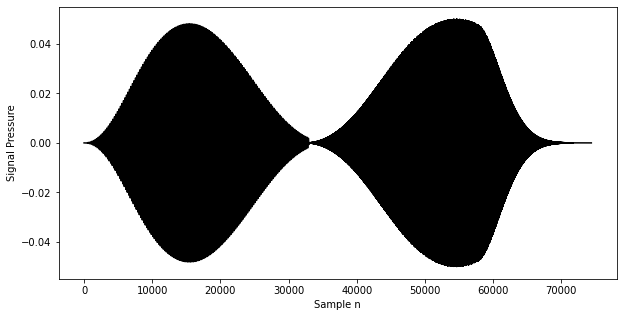

In [4]:
# Plot signal in the time domain
plt.figure(figsize=(10, 5))
plt.plot(audio, color='k')
plt.xlabel('Sample n')
plt.ylabel('Signal Pressure')

    

In [5]:
# # Plot signal in the fourier domain
# audio_fft = np.fft.fft(audio)
# audio_fft_freqs = np.fft.fftfreq(nt, 1/samplerate)

# plt.figure(figsize=(20, 5))
# plt.suptitle('Magnitude of fourier transform')
# plt.subplot(1, 2, 1)
# plt.plot(audio_fft_freqs, np.abs(audio_fft))
# plt.xlabel('Freqs (Hz)')
# plt.ylabel('Magnitude')


# plt.subplot(1, 2, 2)
# plt.plot(audio_fft_freqs, np.abs(audio_fft))
# plt.xlim(0, 5000)
# plt.xlabel('Freqs (Hz)')
# plt.ylabel('Magnitude')

In [6]:
# powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(audio, Fs=samplerate)
# plt.xlabel('Time (Seconds)')
# plt.ylabel('Frequency (hZ)')

 

In [7]:
# # Visualise single gammatone filter
# ffilt = 1000
# gammatone1000 = basilarmembrane.gammatone(ffilt, samplerate)
# w, h = signal.freqz(gammatone1000.b, gammatone1000.a, fs=samplerate)

# plt.plot(w, 20 * np.log10(abs(h)))
# plt.xscale('log')
# plt.title('Gammatone filter frequency response')
# plt.xlabel('Frequency')
# plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
# plt.grid(which='both', axis='both')
# plt.axvline(ffilt, color='green') # cutoff frequency
# plt.show()

In [8]:
# Initialise Model

model = cochlea()
model.set_input(audio, samplerate)

In [9]:
# Generate gammatone basilar membrane filterbank
flims = [200, 4000]
nfilt = 10

#possible basilar membrane filter types:
# gammatone
# transp
model.set_BM('gammatone', flims, nfilt)




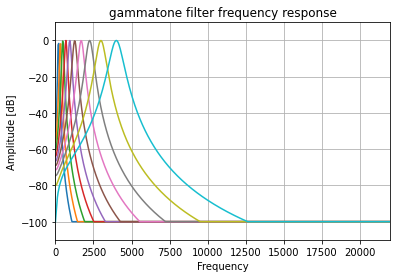

In [10]:
#Plot filters
model.visualise_filters()

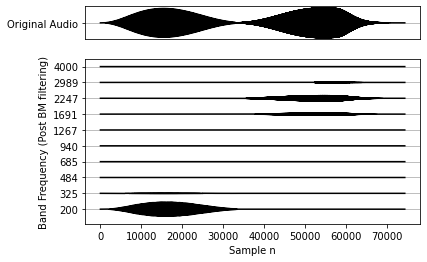

In [11]:
# Filter signal using each band in filterbank (basilar membrane stage 1)
model.filter_bm()

gs = gridspec.GridSpec(2, 1,height_ratios=[2,nfilt])
ax_audio = plt.subplot(gs[0])
ax_audio.plot(audio, color='k')
ax_audio.set_xticks([])
ax_audio.set_yticks([0])
ax_audio.set_yticklabels(['Original Audio'])
plt.grid(which='both', axis='y')    

ax_bm = plt.subplot(gs[1])
model.plot_bm(ax_bm)
plt.grid(which='both', axis='y')    


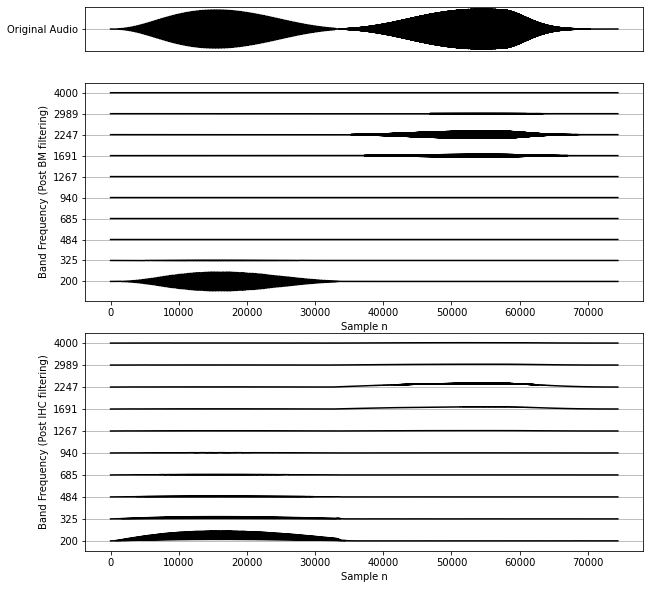

In [12]:
# Filter each band using Bernstein 1999 (IHC stage 2)
model.set_ihc()
model.ihc['filter'].add_bernstein1999(samplerate)

#model.ihc['filter'].add_halfwave()
#model.ihc['filter'].add_lowpass(samplerate, N=4)

#model.ihc['filter'].add_hilbert()

model.filter_ihc()

plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(3, 1,height_ratios=[2, nfilt,nfilt])

ax_audio = plt.subplot(gs[0])
ax_audio.plot(audio, color='k')
ax_audio.set_xticks([])
ax_audio.set_yticks([0])
ax_audio.set_yticklabels(['Original Audio'])
plt.grid(which='both', axis='y')    

ax_bm = plt.subplot(gs[1])
model.plot_bm(ax_bm)
ax_audio.set_xticks([])
plt.grid(which='both', axis='y')    

ax_ihc = plt.subplot(gs[2])
model.plot_ihc(ax_ihc)
plt.grid(which='both', axis='y')    


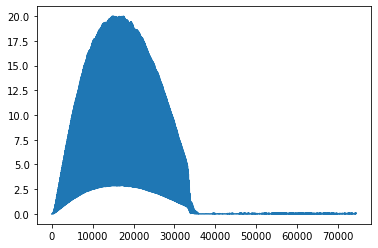

In [23]:
ihc = model.get_signals_ihc()
signal = ihc['200'] *100
plt.plot(signal)

In [24]:
A = 5
B = 160
g = 1660
r = 12500
l = 500
y = 16.6
h = 10000

c = 0
q = 0

In [25]:
def k(s):
    if s > -A:
        permeability = (g * (s + A)) / (s + A + B)
    else:
        permeability = 0
    return permeability

0.0005945088644125274 0.00644552269532458


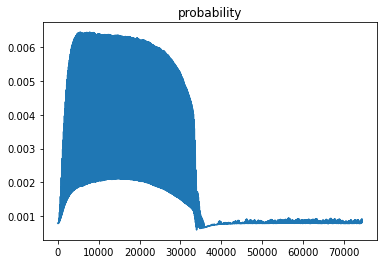

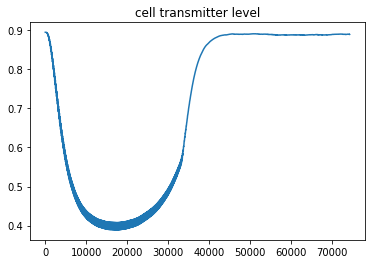

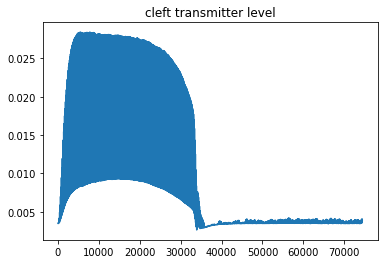

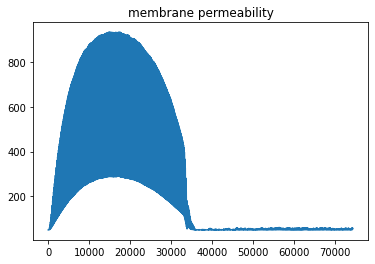

In [30]:
dt = 1/samplerate
signal = ihc['200'] * 1000

probs = []
qs = []
cs = []
ks = []
for i in range(len(signal)):
    ki = k(signal[i])
    ks.append(ki)
    
    dq = (y*(1-q) + (r*c) - (ki*q)) * dt
    dc = ((ki*q) - (l*c) - (r*c)) * dt
    
    q = q + dq
    c = c + dc
    
    qs.append(q)
    cs.append(c)
    
    prob = h * c * dt
    probs.append(prob)
    
plt.figure()    
plt.plot(probs)
plt.title('probability')

plt.figure()
plt.plot(qs)
plt.title('cell transmitter level')

plt.figure()
plt.plot(cs)
plt.title('cleft transmitter level')

plt.figure()
plt.plot(ks)
plt.title('membrane permeability')
print(min(probs), max(probs))
    
    
    


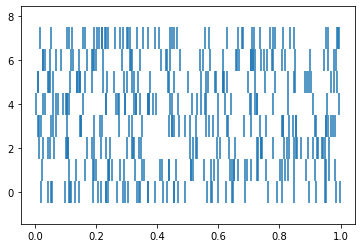

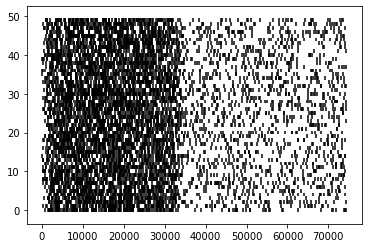

In [69]:
num_neurons = 50

rands = np.random.rand(len(signal), num_neurons)
spike_train = np.zeros(shape=(len(signal), num_neurons))

for n in range(num_neurons):
    spike_train[rands[:,n] < probs, n] = 1

spike_locs = np.where(trains!=0)
spike_lists = []

for ineuron in range(num_neurons):
    spike_lists.append(spike_locs[0][spike_locs[1]==ineuron])

plt.figure()
plt.eventplot(neuralData)
plt.figure()
plt.eventplot(spike_lists, colors='k')

